<a href="https://colab.research.google.com/github/emincingoz/Pneumonia_XRay_Classification/blob/patch_2/Pneumonia_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pneumonia Chest X-Ray Classification

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Activation, Rescaling
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import cv2
import os
%matplotlib inline

In [3]:
print(tf.__version__)

2.8.0


In [4]:
!ls -al MyDrive/CNN

total 3217512
-rw------- 1 root root  824894548 Mar 11 08:46 catsanddogs.zip
drwx------ 2 root root       4096 Mar 18 08:03 checkpoints_best_only
drwx------ 2 root root       4096 Mar 16 06:15 chest_xray
-rw------- 1 root root 2463365435 Feb 23 09:31 chest_xray.zip
-rw------- 1 root root      56096 Feb 20 20:09 fashion_MNIST_CNN.ipynb
-rw------- 1 root root      22508 Feb 16 21:45 gender_classification.ipynb
-rw------- 1 root root    1843072 Mar 11 15:32 Image_Classification_from_Scratch.ipynb
drwx------ 2 root root       4096 Mar 11 08:46 PetImages
-rw------- 1 root root      17908 Mar 18 20:27 Pneumonia_Classification.ipynb
-rw------- 1 root root     464544 Mar 16 08:08 Pneumonia_Detection1.ipynb
drwx------ 2 root root       4096 Mar 16 13:09 __pycache__
-rw------- 1 root root    4042712 Mar 18 18:47 saved_at_7.h5
drwx------ 2 root root       4096 Mar 11 08:18 saved_epochs
-rw------- 1 root root       3062 Mar 17 19:08 tensorflow_dataset_operations.py


In [5]:
#os.chdir('/gdrive/MyDrive/CNN')
#!ls

In [6]:
!ls MyDrive/CNN/chest_xray

chest_xray  __MACOSX  test  train  val


In [7]:
!ls MyDrive/CNN/chest_xray/train

NORMAL	PNEUMONIA


In [8]:
train_path = 'MyDrive/CNN/chest_xray/train'
test_path = 'MyDrive/CNN/chest_xray/test'
val_path = 'MyDrive/CNN/chest_xray/val'

## Filter Out Corrupted Images

In [9]:
def filter_corrupted_images(path):
  labels = ['PNEUMONIA', 'NORMAL']
  num_skipped = 0
  for label in labels:
    fpath = os.path.join(path, label)
    # get image names
    for img in os.listdir(fpath):
      # get image paths
      img_path = os.path.join(fpath, img)
      
      try:
        fobj = open(img_path, 'rb')

        is_jfif = tf.compat.as_bytes('JFIF') in fobj.peek(10)

      finally:
        fobj.close()

      if not is_jfif:
        num_skipped += 1
        os.remove(img_path)

  print('Deleted %d images' % num_skipped)

  return num_skipped

In [10]:
filter_corrupted_images(train_path)
filter_corrupted_images(test_path)
filter_corrupted_images(val_path)

Deleted 0 images
Deleted 0 images
Deleted 0 images


0

## Generate Datasets

In [11]:
image_size = (255, 255)
batch_size = 32
labels = ['NORMAL', 'PNEUMONIA']

#train_path = '/content/drive/MyDrive/CNN/chest_xray/train'
#test_path = '/content/drive/MyDrive/CNN/chest_xray/test'
#val_path = '/content/drive/MyDrive/CNN/chest_xray/val'

In [12]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_ds = image_dataset_from_directory(train_path, 
                                        #validation_split = 0.2, 
                                        #subset = 'training', 
                                        image_size = image_size, 
                                        seed = 132,
                                        batch_size = batch_size, 
                                        color_mode = 'grayscale', 
                                        shuffle = True)

test_ds = image_dataset_from_directory(test_path, 
                                       #validation_split = 0.2,
                                       #subset = 'validation', 
                                       image_size = image_size, 
                                       seed = 132,
                                       batch_size = batch_size, 
                                       color_mode = 'grayscale', 
                                       shuffle = True)


Found 5043 files belonging to 2 classes.
Found 586 files belonging to 2 classes.


In [13]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 255, 255, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [14]:
for images, labels in train_ds:
  print(images.shape)
  print(labels.shape)
  break

(32, 255, 255, 1)
(32,)


## Some Visualizations

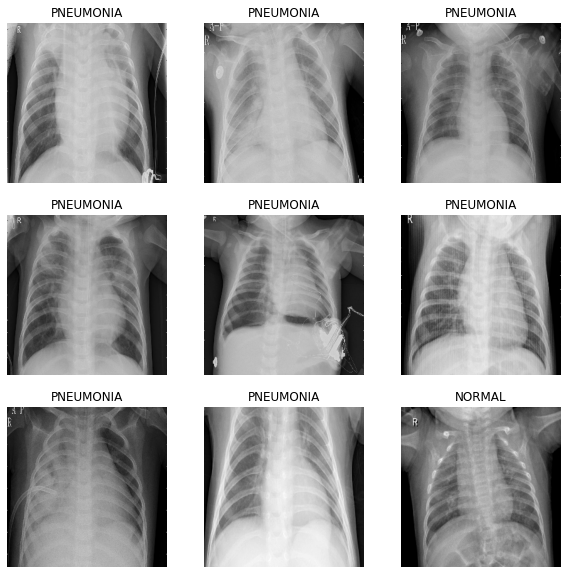

In [15]:
class_names = train_ds.class_names

plt.figure(figsize = (10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(np.squeeze(images[i].numpy().astype('uint8')), cmap = 'gray')
    plt.title(class_names[labels[i]])
    plt.axis('off')

In [16]:
# tf.concat: Concatenates the list of tensors values along dimension axis. 

x_train = tf.concat([x for x, y in train_ds], axis = 0)
y_train = tf.concat([y for x, y in train_ds], axis = 0)

x_test = tf.concat([x for x, y in test_ds], axis = 0)
y_test = tf.concat([y for x, y in test_ds], axis = 0)

tf.compat.v1.enable_eager_execution()

In [17]:
type(x_train)

tensorflow.python.framework.ops.EagerTensor

In [18]:
x_train.shape

TensorShape([5043, 255, 255, 1])

In [19]:
x_train = np.array(x_train).astype('uint8')
y_train = np.array(y_train).astype('uint8')

x_test = np.array(x_test).astype('uint8')
y_test = np.array(y_test).astype('uint8')


In [20]:
x_train.shape

(5043, 255, 255, 1)

In [21]:
type(x_train)

numpy.ndarray

Text(0.5, 1.0, 'PNEUMONIA')

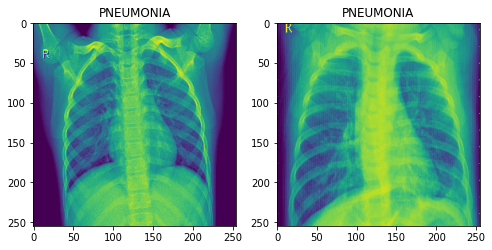

In [22]:
plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(x_train[5]))
plt.title(class_names[y_train[5]])

plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(x_train[4000]))
plt.title(class_names[y_train[4000]])

In [23]:
'''
# import colab py file
from google.colab import drive 
drive.mount('/content/drive')

import sys 
sys.path.insert(0,'/content/drive/My Drive/CNN')

%cd drive/MyDrive/ColabNotebooks %pwd

from tensorflow_dataset_operations import TensorflowDatasetClass as tfds

dataset = tfds(image_size, 1)

train_path_for_myclass = os.path.join('/content/drive', train_path)   # path = '/content/drive/MyDrive/CNN/chest_xray/train'
test_path_for_myclass = os.path.join('/content/drive', test_path)   # path = '/content/drive/MyDrive/CNN/chest_xray/test'
val_path_for_myclass = os.path.join('/content/drive', val_path)   # path = '/content/drive/MyDrive/CNN/chest_xray/val'

temp_train_set = dataset.get_data_tensorflow_dataset(train_path_for_myclass)
temp_test_set = dataset.get_data_tensorflow_dataset(test_path_for_myclass)
temp_val_set = dataset.get_data_tensorflow_dataset(val_path_for_myclass)

images_dataset, labels_dataset = dataset.get_images_and_labels_as_nparray(temp_train_set)

images_dataset.shape

dataset.take_samples(temp_train_set, 9)
'''

"\n# import colab py file\nfrom google.colab import drive \ndrive.mount('/content/drive')\n\nimport sys \nsys.path.insert(0,'/content/drive/My Drive/CNN')\n\n%cd drive/MyDrive/ColabNotebooks %pwd\n\nfrom tensorflow_dataset_operations import TensorflowDatasetClass as tfds\n\ndataset = tfds(image_size, 1)\n\ntrain_path_for_myclass = os.path.join('/content/drive', train_path)   # path = '/content/drive/MyDrive/CNN/chest_xray/train'\ntest_path_for_myclass = os.path.join('/content/drive', test_path)   # path = '/content/drive/MyDrive/CNN/chest_xray/test'\nval_path_for_myclass = os.path.join('/content/drive', val_path)   # path = '/content/drive/MyDrive/CNN/chest_xray/val'\n\ntemp_train_set = dataset.get_data_tensorflow_dataset(train_path_for_myclass)\ntemp_test_set = dataset.get_data_tensorflow_dataset(test_path_for_myclass)\ntemp_val_set = dataset.get_data_tensorflow_dataset(val_path_for_myclass)\n\nimages_dataset, labels_dataset = dataset.get_images_and_labels_as_nparray(temp_train_set)\n

## Standardize the Data

In [24]:
input_shape = image_size + (1,)
input_shape

(255, 255, 1)

In [25]:
inputs = keras.Input(shape = input_shape)

x = layers.Rescaling(1./255)(inputs)
x

<KerasTensor: shape=(None, 255, 255, 1) dtype=float32 (created by layer 'rescaling')>

In [26]:
y_train.size

5043

In [27]:
zeros = 0
ones = 0

for i in range(y_train.size):
  if y_train[i] == 0:
    zeros += 1
  elif y_train[i] == 1:
    ones += 1

print(ones)
print(zeros)

3743
1300


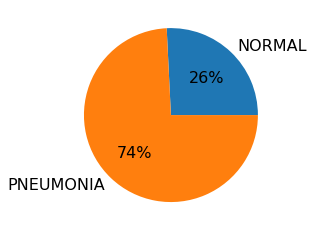

In [28]:
plt.pie((zeros, ones), labels = ['NORMAL', 'PNEUMONIA'], autopct = '%.0f%%', textprops = {'fontsize':16})
plt.show()

<BarContainer object of 2 artists>

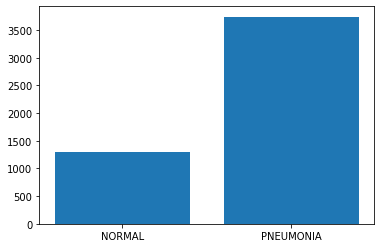

In [29]:
plt.bar(['NORMAL', 'PNEUMONIA'], (zeros, ones))

## Data Augmentation

In [30]:
data_augmentation = keras.Sequential(
    [
          layers.RandomFlip('horizontal'),
          layers.RandomRotation(0.1),
          layers.RandomZoom(0.5),
          layers.RandomContrast(0.2),
          layers.RandomTranslation(0.2, 0.2),
    ]
)

#x_train, y_train = reshape(train_normals[:,0], train_normals[:, 1], (180, 180))

#The ImageDataGenerator requires rank 4 input matrix(Image Index, height, widht, depth).
#data_augmentation.fit(x_train)

## Encoding

In [31]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

## Build Model

In [56]:
def get_model(input_shape, num_classes):
  inputs = keras.Input(shape = input_shape)

  x = data_augmentation(inputs)

  x = layers.Rescaling(1.0/255)(inputs)

  x = layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same', strides = 2, data_format = 'channels_last', kernel_initializer = 'he_normal')(x)
  #x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  x = layers.MaxPool2D(pool_size = 3, strides = 2, padding = 'same')(x)
  x = layers.Dropout(0.5)(x)

  '''
  x = layers.Conv2D(filters = 128, kernel_size = 3, padding = 'same', strides = 3)(x)
  #x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  x = layers.MaxPool2D(pool_size = 3, strides = 2, padding = 'same')(x)
  x = layers.Dropout(0.5)(x)

  '''
  '''

  x = layers.Conv2D(filters = 128, kernel_size = 3, padding = 'same', strides = 3)(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  x = layers.MaxPool2D(pool_size = 3, strides = 2, padding = 'same')(x)
  x = layers.Dropout(0.6)(x)
  '''

  x = layers.Conv2D(filters = 64, kernel_size = 5, padding = 'same', strides = 2)(x)
  #x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  x = layers.MaxPool2D(pool_size = 3, strides = 2, padding = 'same')(x)
  x = layers.Dropout(0.5)(x)

  x = layers.Conv2D(filters = 32, kernel_size = 3, padding = 'same', strides = 2)(x)
  #x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  x = layers.MaxPool2D(pool_size = 3, strides = 2, padding = 'same')(x)
  #x = layers.Dropout(0.6)(x)

  x = layers.Flatten()(x)
  x = layers.Dropout(0.5)(x)

  x = layers.Dense(16, activation = 'relu')(x)
  #x = layers.BatchNormalization()(x)
  #x = layers.Dropout(0.6)(x)
  outputs = layers.Dense(num_classes, activation = 'sigmoid')(x)

  return keras.Model(inputs, outputs)

In [57]:
model = get_model(input_shape = input_shape, num_classes = 1)

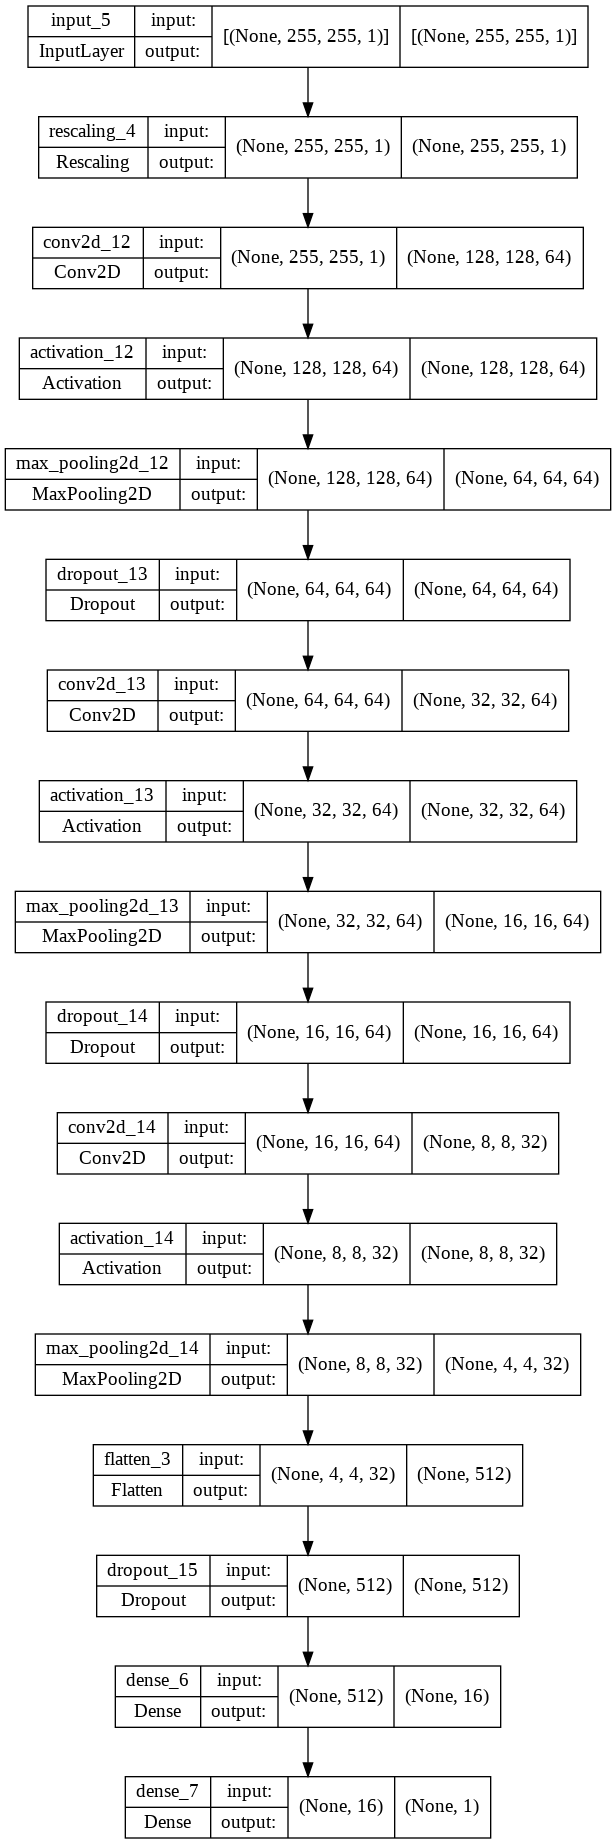

In [58]:
keras.utils.plot_model(model, to_file = '/model_plot.png', show_shapes = True, show_layer_names = True)

In [59]:
def get_checkpoint_best_only():
  best_checkpoint_path = 'MyDrive/CNN/checkpoints_best_only/saved_at_{epoch}.h5'

  best_checkpoint = ModelCheckpoint(best_checkpoint_path, 
                                    save_best_only = True, 
                                    frequency='epoch',
                                    save_weights_only=False,
                                    monitor='val_accuracy',
                                    verbose=1)
  
  return best_checkpoint

In [60]:
def get_early_stopping():
  # patience: Number of epochs with no improvement after which training will be stopped.
  return EarlyStopping(monitor = 'val_loss', patience = 3)

## Train the Model

In [61]:
checkpoints_best_only = get_checkpoint_best_only()
early_stopping = get_early_stopping()

callbacks = [early_stopping, checkpoints_best_only]

In [62]:
model.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [63]:
history = model.fit(train_ds,
                    #x = x_train, 
                    #y = y_train, 
                    epochs = 15, 
                    shuffle = True,  
                    callbacks = callbacks,
                    # validation_data = (x_val, y_val) 
                    validation_data = test_ds)

Epoch 1/15
158/158 [==============================] - ETA: 0s - loss: 0.6209 - accuracy: 0.7271
Epoch 1: val_accuracy improved from -inf to 0.60068, saving model to MyDrive/CNN/checkpoints_best_only/saved_at_1.h5
158/158 [==============================] - 38s 220ms/step - loss: 0.6209 - accuracy: 0.7271 - val_loss: 0.6805 - val_accuracy: 0.6007
Epoch 2/15
158/158 [==============================] - ETA: 0s - loss: 0.4431 - accuracy: 0.7868
Epoch 2: val_accuracy improved from 0.60068 to 0.80205, saving model to MyDrive/CNN/checkpoints_best_only/saved_at_2.h5
158/158 [==============================] - 36s 222ms/step - loss: 0.4431 - accuracy: 0.7868 - val_loss: 0.5981 - val_accuracy: 0.8020
Epoch 3/15
158/158 [==============================] - ETA: 0s - loss: 0.2805 - accuracy: 0.8711
Epoch 3: val_accuracy improved from 0.80205 to 0.82082, saving model to MyDrive/CNN/checkpoints_best_only/saved_at_3.h5
158/158 [==============================] - 34s 207ms/step - loss: 0.2805 - accuracy: 0.

In [64]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 255, 255, 1)]     0         
                                                                 
 rescaling_4 (Rescaling)     (None, 255, 255, 1)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 128, 128, 64)      640       
                                                                 
 activation_12 (Activation)  (None, 128, 128, 64)      0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 64, 64, 64)        0         
                                                           

In [65]:
#model.save('/content/drive/MyDrive/CNN/model.h5')
#model = load_model('model.h5')

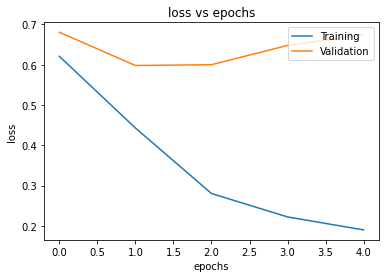

In [66]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss vs epochs')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['Training', 'Validation'], loc = 1)

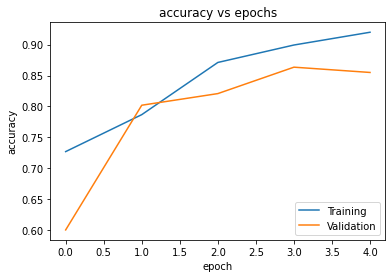

In [67]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('accuracy vs epochs')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Training', 'Validation'], loc = 4)

In [68]:
#x_test, y_test = extract_feature_and_labels(test_set)
#y_test = keras.utils.to_categorical(y_test)

result = model.evaluate(test_ds, verbose = 2)

19/19 - 3s - loss: 0.6742 - accuracy: 0.8549 - 3s/epoch - 175ms/step


In [72]:
print('Test loss: ', result[0])
print('Test accuracy: ', result[1])

Test loss:  0.6741726994514465
Test accuracy:  0.8549488186836243


[[ 78 156]
 [103 249]]


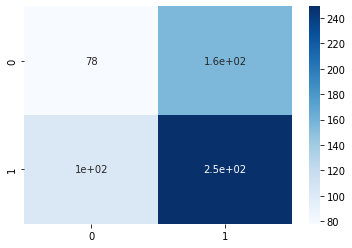

In [75]:
y_pred = model.predict(x_test)
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= .5] = 0

from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true = y_test, y_pred = y_pred)
print(cm)
sns.heatmap(cm, cmap = 'Blues', annot = True)